In [ ]:
# Quantum
import pennylane as qml

# Numericlal
import math
import numpy as np
import sympy as sp

# Torch
import torch
import torch.nn as nn
from torch import optim
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader, random_split

# Plot
import matplotlib.pyplot as plt

%matplotlib inline


---

### Lemma 1

In [4]:
class Lemma1:
    '''
        QAF 논문 Lemma 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, output_num):
        '''
            w(matrix, tensor) : tensor for weights [row0 : w0, row1 : w1, ...], (output_num x input_num)
            x(tensor) : tensor for x(input, list)
            b(tensor) : tensor for bias_list
            output_num(int) : number of output perceptrons (same as len(b))
        '''
        # list(tensor) Initiallize
        self.w = w
        self.x = x
        self.b = b
        self.output_num = output_num

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))
        self.s = int(np.ceil(np.log2(self.output_num)))

        # About x
        self.A_x  = torch.sqrt(torch.tensor(self.N_in) - (self.x @ self.x))
        self.v_x  = torch.cat(( self.A_x.unsqueeze(0)  ,self.x , torch.tensor([1.0]) ,torch.tensor([0.0] * (self.N - self.N_in - 2))))

        # About w, b
        self.A_wb = torch.zeros(self.output_num)
        self.v_wb = torch.zeros(self.output_num, self.N)
        for i in range(len(self.w)):
            self.A_wb[i] = torch.sqrt(torch.tensor(self.N_in) + 1 - (self.w[i] @ self.w[i] + self.b[i] * self.b[i]))
            self.v_wb[i] = torch.cat((torch.tensor([0.0]), self.w[i], self.b[i].unsqueeze(0), torch.tensor([0.0] * (self.N - self.N_in - 3)), self.A_wb[i].unsqueeze(0)))

        self.start_indexes = {
            's' : 0,
            'q' : self.s
        }

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=self.s+self.n)

    def qubit_index(self, name):
        register_name = name[0]
        register_index = int(name[1:])
        return self.start_indexex[register_name] + register_index

    def norm(self, vec):
        return np.linalg.norm(vec)

    def u(self, vec):
        '''
            small u(v_x)
        '''
        qml.AmplitudeEmbedding(vec, wires=range(self.s, self.s + self.n), normalize=True)

    def k_to_control_wire_list(self, k):
        return [int(i) for i in ('0' * (self.s - len(bin(k)[2:]))) + bin(k)[2:]]

    def U_wb(self, index):
        # U_wb, i.e. small_u(v_wb)^†, Pauli-X for each qubit
        qml.adjoint(self.u)(self.v_wb[index])

    def U_z(self):
        # U_x, i.e. small_u(v_x)
        self.u(self.v_x)

        # qml.Barrier()
        if(self.output_num)>1:
            for i in range(self.output_num):
                qml.ctrl(self.U_wb, control=range(self.s), control_values=self.k_to_control_wire_list(i))(i)
        else:
            self.U_wb
                # qml.Barrier()

        # Pauli-X for q register
        q0 = self.s
        for i in range(self.n):
            qml.PauliX(wires=q0+i)

    def hadamard_s(self):
        # Hadamard for all qubit of l register
        for i in range(self.s):
            qml.Hadamard(wires=i)

    def outer_lemma1(self):
        self.hadamard_s()
        self.U_z()


    def lemma1(self, chk=False):
        @qml.qnode(device=self.dev ,interface="torch")
        def inner_lemma1():
            self.outer_lemma1()
            return qml.state()
        if chk:
            print(qml.draw_mpl(inner_lemma1)())
        return inner_lemma1()

    def get_z(self, k, chk=False):
        '''
            k번째 wegiht에 대한 z를 구해준다.
        '''
        bit_string = '0' * (self.s - len(bin(k)[2:])) + bin(k)[2:]
        index = int(bit_string + '1' * self.n, 2)
        result = self.lemma1(chk=chk)
        return result[index] * (2 ** (self.s / 2))

    def get_z_list(self):
        return [self.get_z(i) for i in range(self.output_num)]



(<Figure size 900x600 with 1 Axes>, <Axes: >)


(tensor(0.3623+0.j, dtype=torch.complex128),
 tensor([0.3623, 0.4409, 0.4036, 0.3799]))

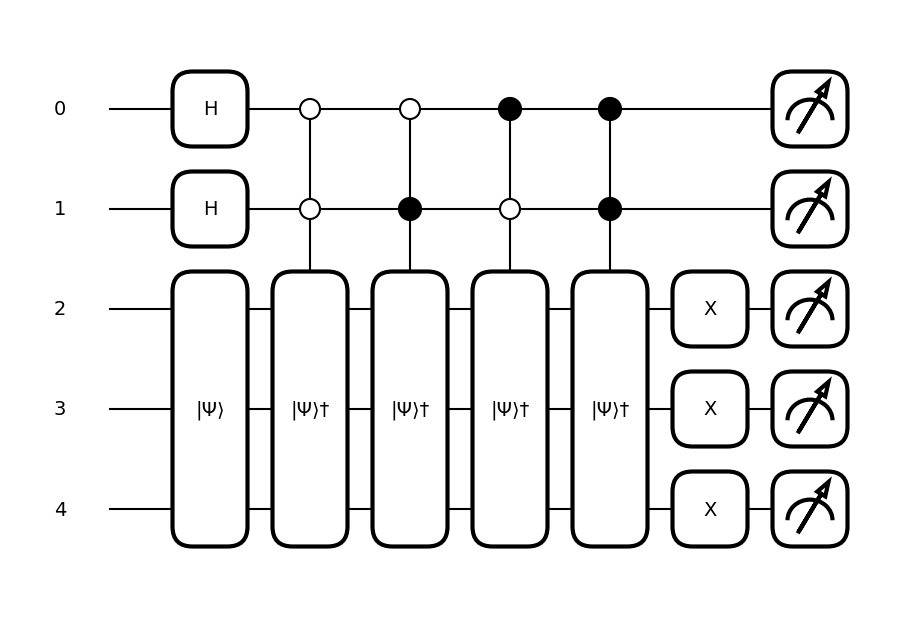

In [5]:
num_of_weight = 4
element_of_weight = 4
w = torch.rand(num_of_weight, element_of_weight)
x = torch.rand(element_of_weight)
bias = torch.rand(num_of_weight)
z = (w @ x + bias) / (len(x) + 1)
test1 = Lemma1(w=w, x=x, b=bias, output_num=num_of_weight)

test1.get_z(k=0, chk=True), z

---

### Theorem 1, Corollary 1

In [6]:
class Theorem1(Lemma1):
    '''
        QAF 논문 Theorem 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, d, l = 0):
        '''
            w(matrix, tensor) : tensor for weights [row0 : w0, row1 : w1, ...], (output_num x input_num)
            x(tensor) : tensor for x(input, list)
            b(tensor) : tensor for bias_list
            d(int)      : degree for Taylor (polynomial) Expansion
        '''
        super().__init__(w, x, b, output_num=len(b))
        self.d = d
        self.l = l

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=(self.s + self.n + self.d + self.l))

    def V(self, m):
        a_m = self.s + self.n + m

        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.s, self.s + self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            q_i = self.s + i
            qml.CNOT(wires=[a_m, q_i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            q_i = self.s + i
            qml.PauliX(wires=q_i)

        self.hadamard_s()
        qml.Barrier()
        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)
            qml.Barrier()

    def theorem1(self, chk=False):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev)
        def inner_theorem1():
            self.outer_theorem1()
            return qml.state()
        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def corollary1(self, k, w_index):
        '''
            k를 input으로 받아, |w_index>(s) |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem1()
        w_bitstring = '0' * (self.s - len(bin(w_index)[2:])) + bin(w_index)[2:]
        bitstring = w_bitstring + ('1' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return (result[index] * (2 ** ((self.s / 2) + (self.d / 2)))) ** (1 / k)

    def get_z_list(self):
        '''
            k=d 고정, 모든 weight에 대한 z값 리스트 리턴
        '''
        return [self.corollary1(k=self.d, w_index=i) for i in range(self.output_num)]

(<Figure size 4400x900 with 1 Axes>, <Axes: >)


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of typ

([tensor(0.4560+0.j, dtype=torch.complex128),
  tensor(0.3397+0.j, dtype=torch.complex128),
  tensor(0.3656+0.j, dtype=torch.complex128),
  tensor(0.4789+0.j, dtype=torch.complex128)],
 tensor([0.4560, 0.3397, 0.3656, 0.4789]))

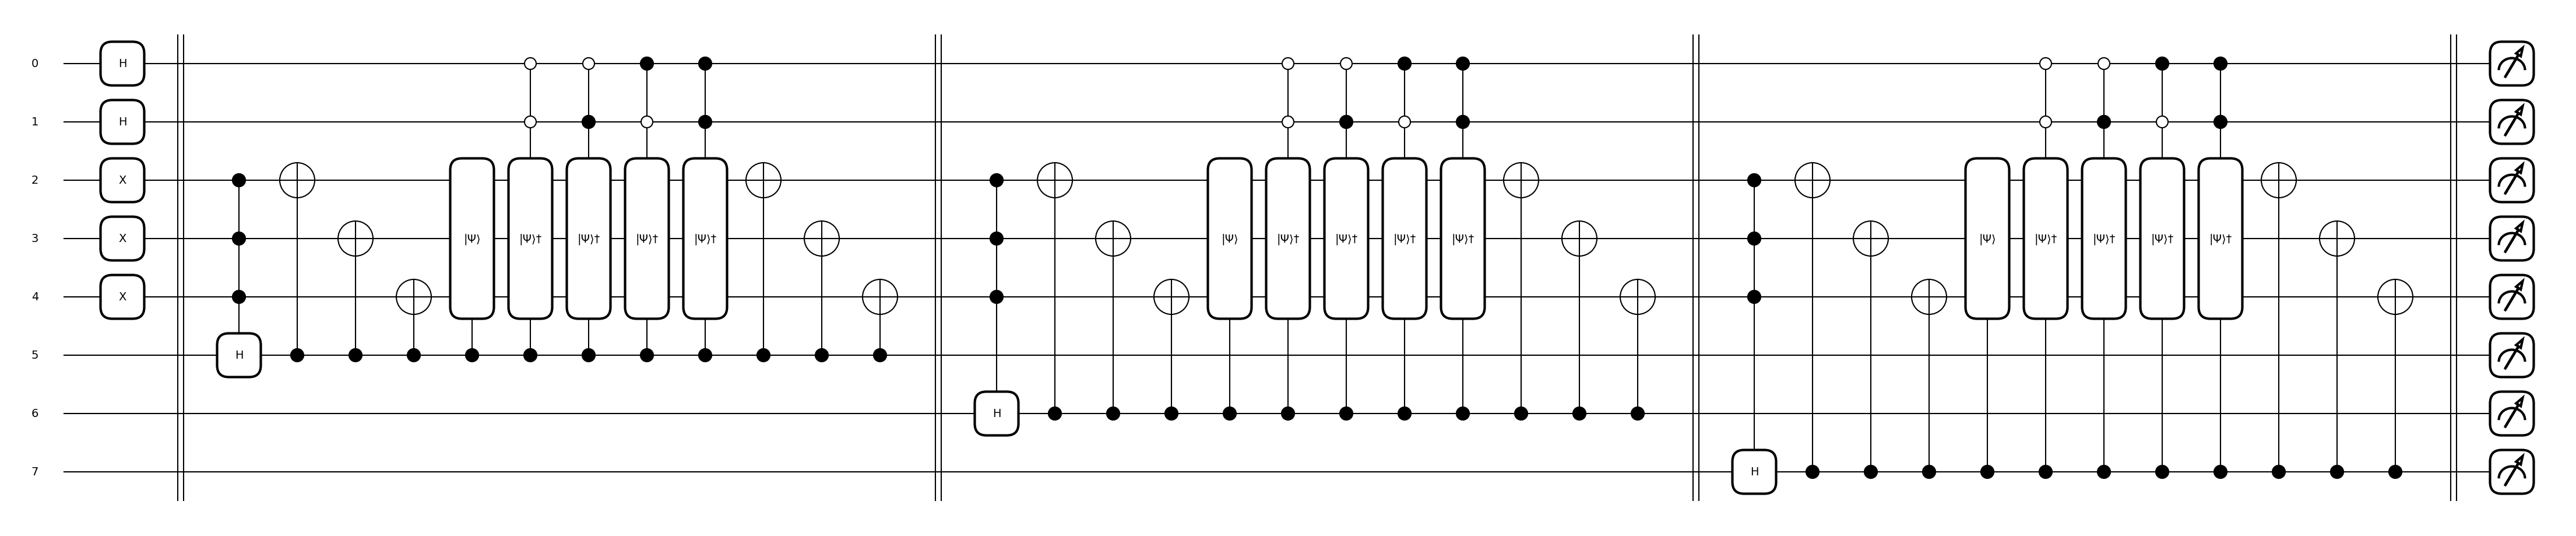

In [7]:
num_of_weight = 4
element_of_weight = 4
torch.manual_seed(42)
w = torch.rand(num_of_weight, element_of_weight)
x = torch.rand(element_of_weight)
bias = torch.rand(num_of_weight)
d = 3

# print('w :', w)
# print('x :', x)

z = (w @ x + bias) / (len(x) + 1)

test2 = Theorem1(w=w, x=x, b=bias, d=d)
test2.theorem1(chk=True)
test2.get_z_list(), z

---

### Theorem 2

In [8]:
class Theorem2(Theorem1):
    def __init__(self, w, x, b, d, f, l = 0):
        '''
            w, x, b, d : same as Thm1
            f(str) : name of function which will be sympified
        '''

        # print('Before Thm1 Init')
        super().__init__(w, x, b, d, l=l)
        # print('After Thm1 Init')
        self.f = sp.sympify(f) # target f
        self.k = -1     # target f의 taylor expansion 중 계수가 0이 아닌 최저 차수
        self.C_d = 1    # f_d(z)와 실제 f(z)의 factoring constant
        self.theta_list = self.make_theta_list()


    def taylor_series_coefficients(self):
        # 심볼 정의
        z = sp.symbols('z')
        point = 0.0

        # 테일러 전개 계산
        taylor_expansion = sp.series(self.f, z, point, self.d + 1).removeO()

        # 계수 추출
        coeffs = [taylor_expansion.coeff(z, i) for i in range(self.d + 1)]
        return coeffs

    def make_theta_list(self):
        # Get Coeffs of Taylor (polynomial) Expansion of target f
        coefficients = self.taylor_series_coefficients()

        # Update k (target f의 taylor expansion 중 계수가 0이 아닌 최저 차수)
        for i in range(0, self.d + 1):
            if coefficients[i] != 0:
                self.k = i
                break

        theta_list = [0 for _ in range(self.d)]
        # target f = 0
        if self.k < 0:
            return theta_list

        # a_i = 0 for all i < k
        for i in range(self.k):
            theta_list[i] = -1 * math.pi / 2

        # a_k Initiallization
        theta_list[self.k] = math.atan(-1 * coefficients[self.k + 1] / coefficients[self.k])

        A = 1
        for i in range(self.k + 1, len(coefficients) - 1):
            A *= math.cos(theta_list[i - 1])
            theta_list[i] = math.atan(-1 * coefficients[i + 1] / coefficients[self.k] * A)

        # C_d update
        C_d = coefficients[self.k] # a_k
        for i in range(self.k, self.d):
            C_d /= math.cos(theta_list[i]) # 1/cos(theta)
        self.C_d = torch.tensor([float(C_d)])

        return theta_list

    def U(self, d):
        '''
            U_d Unitary for S_U iteration
        '''
        theta_list = self.theta_list # make_theta_list()
        for k in range(1, d):
            a_0 = self.s + self.n
            a_k = a_0 + k
            qml.ctrl(qml.RY, control=a_k, control_values=0)(2 * theta_list[k - 1], wires=a_0)
            qml.CNOT(wires=[a_0, a_k])

    def outer_theorem2(self):
        '''
            S_U := d register에는 U_d, q register에는 Pauli-X for each qubit
        '''
        # Pauli-X for each qubit of q register
        # and S_V
        self.outer_theorem1()

        qml.Barrier()

        # U_d
        self.U(self.d)

        qml.Barrier()

        # Pauli-X for each qubit of q register
        for i in range(self.n):
            q_i = self.s + i
            qml.PauliX(wires=q_i)

    def theorem2(self, chk=False):
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem2():
            self.outer_theorem2()
            return qml.state()
        if chk:
            print(qml.draw_mpl(self.outer_theorem2, style='pennylane')())
        return inner_theorem2()

    def corollary2(self, k, w_index):
        '''
            as same as col 1,
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem2()
        w_bitstring = '0' * (self.s - len(bin(w_index)[2:])) + bin(w_index)[2:]
        bitstring = w_bitstring + ('0' * self.n) + ('0' * (self.d ))
        index = int(bitstring, 2)
        return result[index] * (2 ** (self.s / 2 + self.d / 2)) * self.C_d # * C_d

    def get_z_list(self):
        result = self.theorem2()
        z_list= []
        for i in range(self.output_num):
            w_bitstring = '0' * (self.s - len(bin(i)[2:])) + bin(i)[2:]
            bitstring = w_bitstring + ('0' * self.n) + ('0' * (self.d ))
            index = int(bitstring, 2)
            z_list.append(result[index] * (2 ** (self.s / 2 + self.d / 2)) * self.C_d)

        return z_list

Matplotlib is building the font cache; this may take a moment.


(<Figure size 4500x800 with 1 Axes>, <Axes: >)


([tensor([0.3653+0.j]), tensor([0.3724+0.j])], tensor([0.3526, 0.3592]))

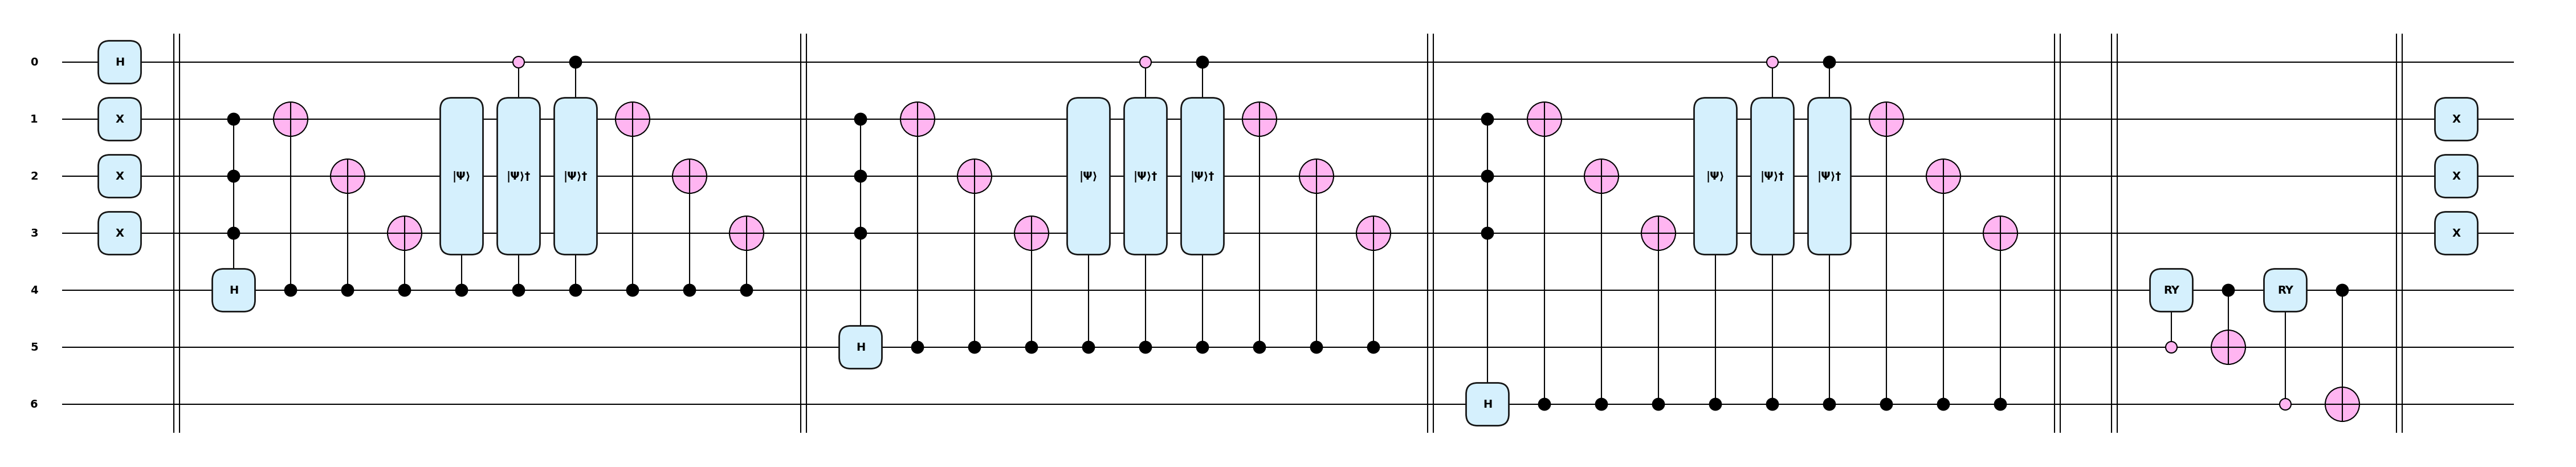

In [9]:
num_of_weight = 2
element_of_weight = 4
torch.manual_seed(41)
w = torch.rand(num_of_weight, element_of_weight)
x = torch.rand(element_of_weight)
bias = torch.rand(num_of_weight)
d = 3
func = 'sin(z)'

# print('w :', w)
# print('x :', x)

z = (w @ x + bias) / (len(x) + 1)

test2 = Theorem2(w=w, x=x, b=bias, d=d, f=func, l=0)
test2.theorem2(chk=True)
test2.corollary2(k=num_of_weight, w_index=num_of_weight-1), np.sin(z)
test2.get_z_list() ,np.sin(z)

In [10]:
# Define the parameters
num_of_weight = 2
element_of_weight = 4
torch.manual_seed(32)
w = torch.rand(num_of_weight, element_of_weight)
bias = torch.rand(num_of_weight)
d = 5
func = 'sin(z)'

# Create Theorem2 instance


# Define the range of t values
t_values = np.linspace(-1, 1, 100)
d_outputs =[]
for d in range(2,6):
  theorem2_outputs = []
  wx_b_outputs = []
  for t in t_values:
    # Initialize lists to store the results
    x = torch.tensor([t*0.1, t*0.2, t*(-1)*t*0.3, t*t*0.4], dtype=torch.float32)
    wx_b = (w @ x + bias) / (len(x) + 1)
    wx_b_activated = torch.sin(wx_b)

    theorem2_instance = Theorem2(w=w, x=x, b=bias, d=d, f=func)
    theorem2_output = theorem2_instance.get_z_list()

    theorem2_outputs.append(theorem2_output)
    wx_b_outputs.append(wx_b_activated)

    # Convert the results to numpy arrays for plotting
  d_outputs.append(np.array(theorem2_outputs))
wx_b_outputs = np.array(wx_b_outputs)


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


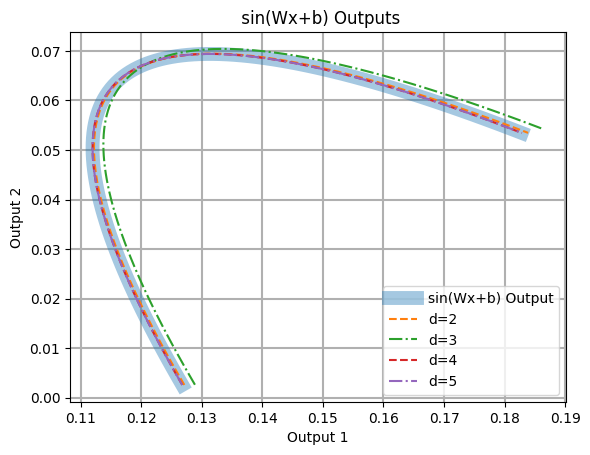

In [11]:
plt.plot(wx_b_outputs[:, 0], wx_b_outputs[:, 1], label=f'sin(Wx+b) Output' ,linewidth=10 ,alpha=0.4)
for idx, out in enumerate(d_outputs):
  plt.plot(out[:, 0], out[:, 1],label=f'd={2+idx}' ,linestyle='--' if idx % 2 == 0 else '-.')
plt.xlabel('Output 1')
plt.ylabel('Output 2')
plt.title(' sin(Wx+b) Outputs')
plt.legend()
plt.grid(True, linewidth=1.5)
plt.show()


---